In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import csv
import numpy as np
from IPython import display
import GPflow

#This script replicates Hensman, Matthews, Ghahramani, AISTATS 2015...
#... Scalable Variational Gaussian Process Classification...
#.... Figure 1 Row1.
#It serves to demonstrate sparse variational GP classification...
#... on a simple, easily visualized dataset.

def readCsvFile( fileName ):
    reader = csv.reader(open(fileName,'r') )
    dataList = []
    for row in reader:
        dataList.append( [float(elem) for elem in row ] )
    
    return np.array( dataList )

def getData():
   Xtrain = readCsvFile('data/banana_X_train')
   Ytrain = readCsvFile('data/banana_Y_train')
   return Xtrain, Ytrain

def gridParams():
   mins = [-3.25,-2.85 ] 
   maxs = [ 3.65, 3.4 ]
   nGrid = 50
   xspaced = np.linspace( mins[0], maxs[0], nGrid )
   yspaced = np.linspace( mins[1], maxs[1], nGrid )
   xx, yy = np.meshgrid( xspaced, yspaced )
   Xplot = np.vstack((xx.flatten(),yy.flatten())).T
   return mins, maxs, xx, yy, Xplot

def preparePlots(axes):
   mins, maxs, xx, yy, Xplot = gridParams()
   for ax in axes:
      ax.set(adjustable='box-forced', aspect='equal')    
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xlim(mins[0], maxs[0])
      ax.set_ylim(mins[1], maxs[1])
        
def plot(p, ax, Z):
   col1='#0172B2'
   col2= '#CC6600'
   mins, maxs, xx, yy, Xplot = gridParams()
   ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, mew=0, alpha=0.5)
   ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o', color=col2, mew=0, alpha=0.5)
   ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
   ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)

def kernel():
   nDim = 2
   kern = GPflow.kernels.RBF(nDim) + GPflow.kernels.White(nDim)
   kern.white.variance = 0.01
   return kern

def likelihood():
   return GPflow.likelihoods.Bernoulli()

def toggleHypers(model,fixed):
   model.kern.rbf.lengthscales.fixed = fixed
   model.kern.rbf.variance.fixed = fixed
   model.kern.white.variance.fixed = fixed
   return model 

def refreshPlot(fig):
   display.clear_output(wait=True)
   display.display(fig)    

compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state


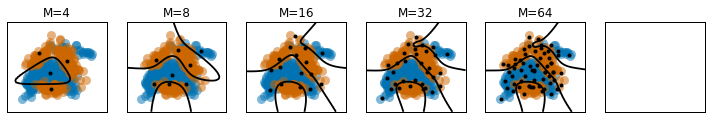

In [2]:
#Setup the experiment and plotting.
Ms = [4,8,16,32,64]

Xtrain, Ytrain = getData()

#prepare plots.
Xplot = gridParams()[-1]
fig, axes = plt.subplots(1,len(Ms)+1, figsize=(12.5, 2.5))
preparePlots(axes)

max_iters = 1000

#Run sparse classification with increasing number of inducing points
for index, num_inducing in enumerate(Ms):
   #kmeans for selecting Z
   from scipy.cluster.vq import kmeans
   Z = kmeans(Xtrain, num_inducing)[0]
   
   m1 = GPflow.svgp.SVGP(Xtrain, Ytrain, kern=kernel(), likelihood=likelihood(), Z=Z )
   #Initially fix the hyperparameters.
   toggleHypers( m1, True )
   m1.optimize(max_iters=max_iters)
   
   #Unfix the hyperparameters.
   toggleHypers( m1, False )
   m1.optimize(max_iters=max_iters)
   
   p1 = m1.predict_y(Xplot)[0]
   plot(p1, axes[index], m1.Z.value)    
   axes[index].set_title('M=%i'%num_inducing)


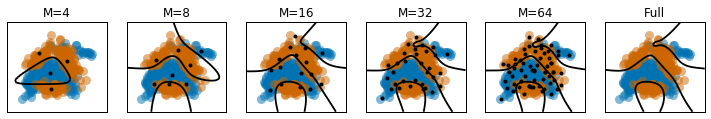

In [3]:
#Run variational approximation without sparsity..
#..be aware that this is much slower.
m = GPflow.vgp.VGP(Xtrain, Ytrain, kern=kernel(), likelihood=likelihood() )
m.optimize(max_iters=max_iters*10)
plot(m.predict_y(Xplot)[0], axes[-1], np.zeros((0,2)))
axes[-1].set_title('Full')

refreshPlot(fig)